In [1]:
from pathlib import Path
import numpy as np
import datetime
import json
import os
import pandas as pd
import rasterio
import skimage.io as skio
from PIL import Image
from cropmask.coco_convert import split_save_train_validation_test_df, save_coco_annotation, create_coco_dataset
from cropmask.misc import parse_yaml, make_dirs

from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.
from detectron2.data.datasets import register_coco_instances, load_coco_json

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
import random
from skimage.io import imshow, imread
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor, launch
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from cropmask.misc import max_normalize, percentile_rescale
from cropmask.detectron2_cropmask_cfg_denmark import cfg
from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.

def read_and_mean(path):
    arr = skio.imread(path)
    fill_values = np.mean(arr, axis=(0, 1))
    return fill_values
    
def read_and_variance(path):
    arr = skio.imread(path)
    fill_values = np.var(arr, axis=(0, 1))
    return fill_values

def calc_stat(df, func, include_empty=False):
    """
    func should operate on a single array of order [band, H, W]
    """
    df = df.copy()
    new_df = df[df.is_empty == include_empty]
    new_df['fill_values'] = new_df['jpeg_tiles'].apply(func)
    new_df = pd.DataFrame(new_df.fill_values.tolist(), columns=['0', '1', '2'])
    return new_df

def max_norm_channels(arr):
    """
    arr must be of shape (w, h, channel)
    """
    arr = arr.copy()
    maxes = np.nanmax(arr, axis=(0,1))
    return arr / maxes

def make_vis_im(img):
    img = img[:, :, ::-1]
    normalized = max_norm_channels(np.where(img < 0, 0, img))
    rescaled = rescale_intensity(normalized, out_range=(0,255))
    masked = np.where(rescaled==0, np.nan, rescaled)
    return masked

# mean_df = calc_stat(train, read_and_mean)
# var_df = calc_stat(train, read_and_variance)

# channel_means = mean_df.mean(axis=0).values
# channel_stds = np.sqrt(var_df.mean(axis=0).values)

outpath = Path(r'/datadrive/denmark-data/preprocessed')
train_coco_instances_path = outpath / r'annotations/instances_train2016.json'
val_coco_instances_path = outpath / r'annotations/instances_val2016.json'
im_tiles_path = outpath / r'images/train2016'
val_tiles_path = outpath / r'images/val2016'
# test_coco_instances_path = str(coco_path / "instances_test.json") christoph didn't use an entirely unique test set, used empty chips not used in training or validation + the validation set

/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/pyt

In [2]:
 str(val_tiles_path)

'/datadrive/denmark-data/preprocessed/images/val2016'

In [3]:
# register each val and test set if there are more than one.
register_coco_instances(cfg.DATASETS.TRAIN[0], {}, str(train_coco_instances_path), str(im_tiles_path))
register_coco_instances(cfg.DATASETS.VALIDATION[0], {}, str(val_coco_instances_path), str(val_tiles_path))
#     register_coco_instances(cfg.DATASETS.TEST[0], {}, test_coco_instances_path, str(next(tiles_path.glob("*jpeg*"))))

train_json = load_coco_json(str(train_coco_instances_path),  str(im_tiles_path))
val_json = load_coco_json(str(val_coco_instances_path),  str(val_tiles_path))
#test_json = load_coco_json(test_coco_instances_path,  str(next(tiles_path.glob("*jpg*"))))

[03/29 00:25:21 d2.data.datasets.coco]: Loaded 754 images in COCO format from /datadrive/denmark-data/preprocessed/annotations/instances_train2016.json
[03/29 00:25:21 d2.data.datasets.coco]: Loaded 189 images in COCO format from /datadrive/denmark-data/preprocessed/annotations/instances_val2016.json


### Printing Truth Labels and Images

In [4]:
from detectron2.data.detection_utils import *

In [5]:
annotations = pd.DataFrame.from_dict(train_json)["annotations"].explode().apply(pd.Series)

In [6]:
annotations_val = pd.DataFrame.from_dict(val_json)["annotations"].explode().apply(pd.Series)

In [7]:
np.unique(annotations_val['category_id'])

array([1])

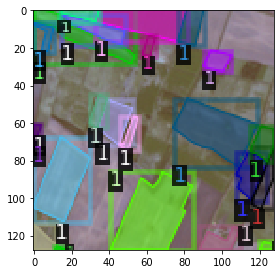

In [8]:
for d in random.sample(train_json, 1):
    if len(d['annotations']) > 0:
        img = imread(d["file_name"])
        img = img[:, :, ::-1]
#         normalized = max_norm_channels(np.where(img < 0, 0, img))
#         rescaled = rescale_intensity(normalized, out_range=(0,255))
#         masked = np.where(rescaled==0, np.nan, rescaled)
        visualizer = Visualizer(img, metadata={}, scale=1)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(figsize = (4,8))
        imshow(vis.get_image())

# Model Inspection

Something to check, there is a predicted category "2" even though we only have 1 category, "1". in the dataset. might be because of the config expectign multiple COCO classes? need to look at shape of last layer of the model in pytorch somehow. after looking at the number of categorie sint he val dataset that faile dto run it looks like the correct num of categories, 2 is present which means detectron2 is probably expecting that there should be 81 categories becuase the model head was not reset because 81 was kept in the config.

In [9]:
cfg.MODEL.WEIGHTS = os.path.join("/datadrive/cropmask_experiments/denmark-smallanchorscales-long/", "model_0003799.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

In [10]:
weights = torch.load(cfg.MODEL.WEIGHTS)


In [11]:
[key for key in weights['model'].keys() if "backbone" not in key]

['proposal_generator.anchor_generator.cell_anchors.0',
 'proposal_generator.anchor_generator.cell_anchors.1',
 'proposal_generator.anchor_generator.cell_anchors.2',
 'proposal_generator.anchor_generator.cell_anchors.3',
 'proposal_generator.anchor_generator.cell_anchors.4',
 'proposal_generator.rpn_head.conv.weight',
 'proposal_generator.rpn_head.conv.bias',
 'proposal_generator.rpn_head.objectness_logits.weight',
 'proposal_generator.rpn_head.objectness_logits.bias',
 'proposal_generator.rpn_head.anchor_deltas.weight',
 'proposal_generator.rpn_head.anchor_deltas.bias',
 'roi_heads.box_head.fc1.weight',
 'roi_heads.box_head.fc1.bias',
 'roi_heads.box_head.fc2.weight',
 'roi_heads.box_head.fc2.bias',
 'roi_heads.box_predictor.cls_score.weight',
 'roi_heads.box_predictor.cls_score.bias',
 'roi_heads.box_predictor.bbox_pred.weight',
 'roi_heads.box_predictor.bbox_pred.bias',
 'roi_heads.mask_head.mask_fcn1.weight',
 'roi_heads.mask_head.mask_fcn1.bias',
 'roi_heads.mask_head.mask_fcn2.wei

In [12]:
neb_weights = torch.load(os.path.join("/datadrive/cropmask_experiments/nirrg-nms7/", "model_0002399.pth"))

looks like wrong weights for denmark model, correct weights for cropmask model.

In [13]:
neb_weights['model']['roi_heads.mask_head.predictor.weight'].shape

torch.Size([1, 256, 1, 1])

In [14]:
weights['model']['roi_heads.mask_head.predictor.weight'].shape

torch.Size([80, 256, 1, 1])

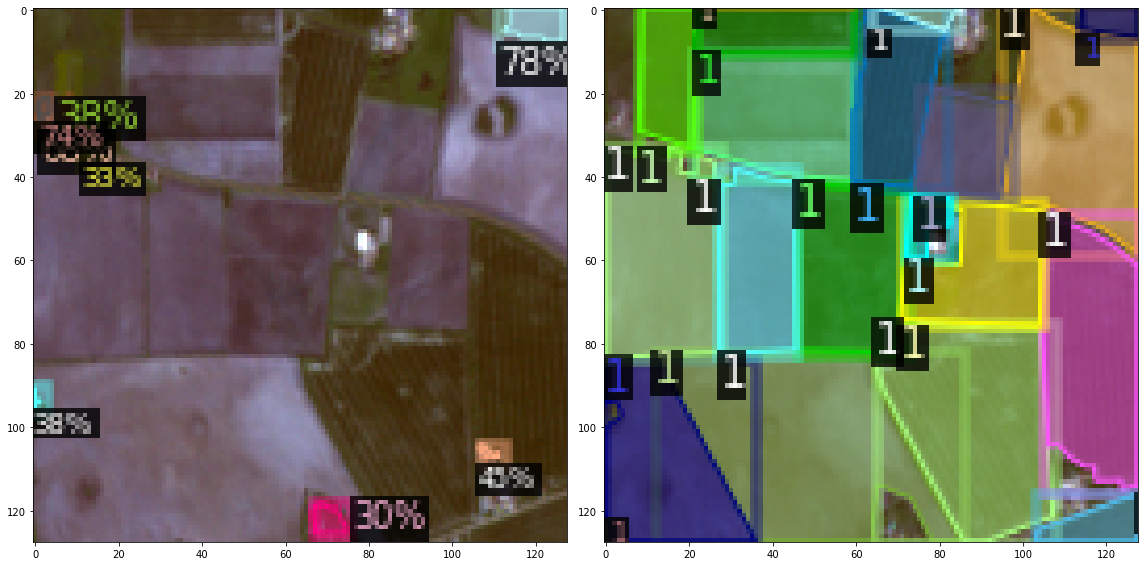

In [15]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(train_json, 1):    
    im = imread(d["file_name"])
    outputs = predictor(im)
    vis_im = make_vis_im(im)
    visualizer_preds = Visualizer(vis_im,
                   scale=1, 
                   metadata= {}   # remove the colors of unsegmented pixels
    )
    visualizer_labels = Visualizer(vis_im,
                   scale=1, 
                   metadata= {}   # remove the colors of unsegmented pixels
    )
    v = visualizer_preds.draw_instance_predictions(outputs["instances"].to("cpu"))
    labels = visualizer_labels.draw_dataset_dict(d)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,16))
    imshow(v.get_image(), ax=ax[0])
    imshow(labels.get_image(), ax=ax[1])

In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("validation", cfg, False, output_dir="/datadrive/evaluator_output/")
test_loader = build_detection_test_loader(cfg, cfg.DATASETS.VALIDATION[0])

[03/29 00:26:03 d2.data.datasets.coco]: Loaded 189 images in COCO format from /datadrive/denmark-data/preprocessed/annotations/instances_val2016.json
[03/29 00:26:03 d2.data.build]: Distribution of instances among all 1 categories:
|   category    | #instances   |
|:-------------:|:-------------|
| agfields_si.. | 4644         |
|               |              |
[03/29 00:26:03 d2.data.common]: Serializing 189 elements to byte tensors and concatenating them all ...
[03/29 00:26:03 d2.data.common]: Serialized dataset takes 0.98 MiB


In [18]:
inference_on_dataset(predictor.model, test_loader, evaluator)
# another equivalent way is to use trainer.test

[03/29 00:26:03 d2.evaluation.evaluator]: Start inference on 189 images
[03/29 00:26:04 d2.evaluation.evaluator]: Inference done 11/189. 0.0632 s / img. ETA=0:00:11
[03/29 00:26:09 d2.evaluation.evaluator]: Inference done 89/189. 0.0623 s / img. ETA=0:00:06
[03/29 00:26:14 d2.evaluation.evaluator]: Inference done 167/189. 0.0623 s / img. ETA=0:00:01
[03/29 00:26:16 d2.evaluation.evaluator]: Total inference time: 0:00:11.883466 (0.064584 s / img per device, on 1 devices)
[03/29 00:26:16 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:11 (0.062299 s / img per device, on 1 devices)
[03/29 00:26:16 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...


AssertionError: A prediction has category_id=2, which is not available in the dataset.

In [22]:
import torch
torch.load("/home/ryan/InstanceSegmentation_Sentinel2/model/resnet_v1_101-0000.params")

UnpicklingError: invalid load key, '\x12'.